### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/images/*')
train_labels = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 366 elements
My custom valing-dataset has 123 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

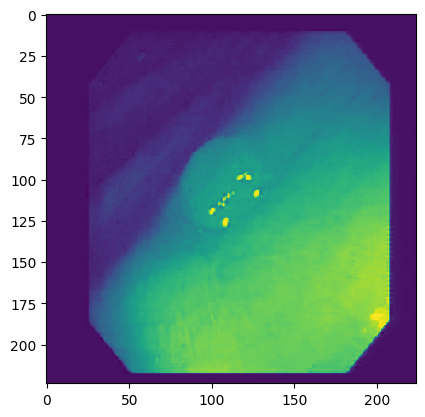

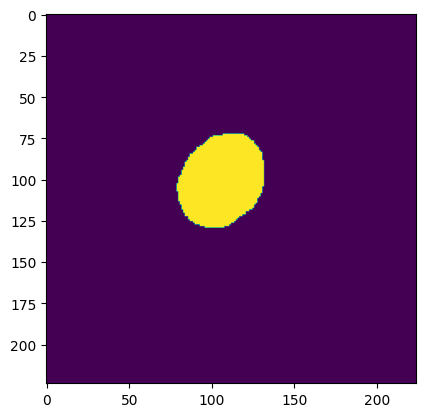

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [8]:
# Begin training
from models.unet import UNet
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'Unet'
data_name = 'CVC'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 46 of 46, Train Loss: 1.225772, IoU: 0.234226, Dice: 0.337961
 Epoch: 1 of 100, Iter.: 46 of 46, Valid Loss: 1.338504, IoU: 0.170834, Dice: 0.257832

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


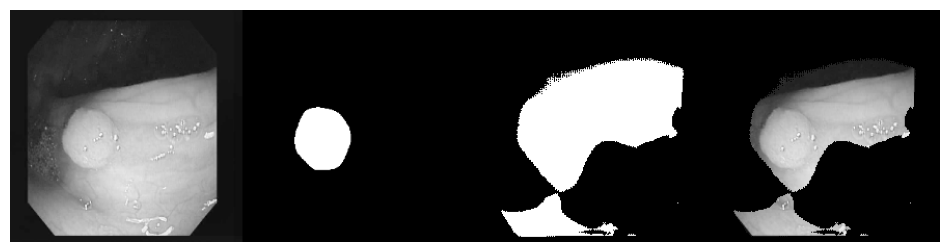

 Epoch: 2 of 100, Iter.: 46 of 46, Train Loss: 1.093481, IoU: 0.295057, Dice: 0.407454
 Epoch: 2 of 100, Iter.: 46 of 46, Valid Loss: 1.529746, IoU: 0.221204, Dice: 0.334612


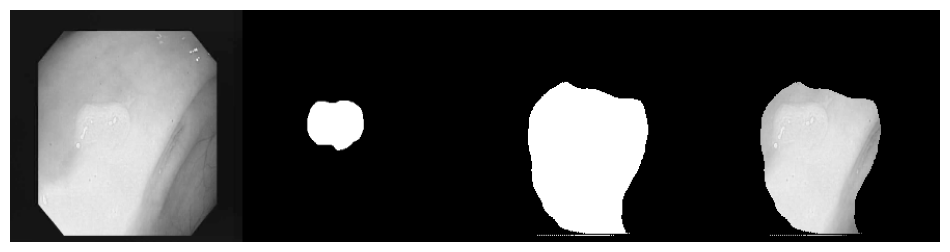

 Epoch: 3 of 100, Iter.: 46 of 46, Train Loss: 1.026750, IoU: 0.339420, Dice: 0.454140
 Epoch: 3 of 100, Iter.: 46 of 46, Valid Loss: 1.045250, IoU: 0.314954, Dice: 0.439928


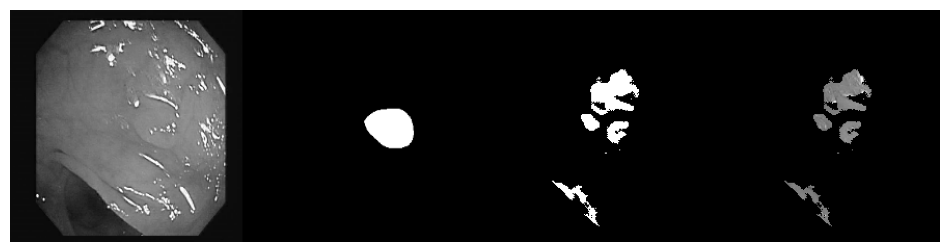

 Epoch: 4 of 100, Iter.: 46 of 46, Train Loss: 0.957334, IoU: 0.369917, Dice: 0.484540
 Epoch: 4 of 100, Iter.: 46 of 46, Valid Loss: 1.038009, IoU: 0.303931, Dice: 0.425873


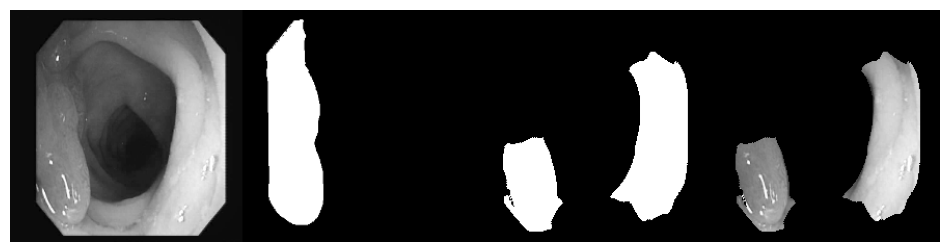

 Epoch: 5 of 100, Iter.: 46 of 46, Train Loss: 0.923904, IoU: 0.392218, Dice: 0.510063
 Epoch: 5 of 100, Iter.: 46 of 46, Valid Loss: 1.020856, IoU: 0.313129, Dice: 0.425783


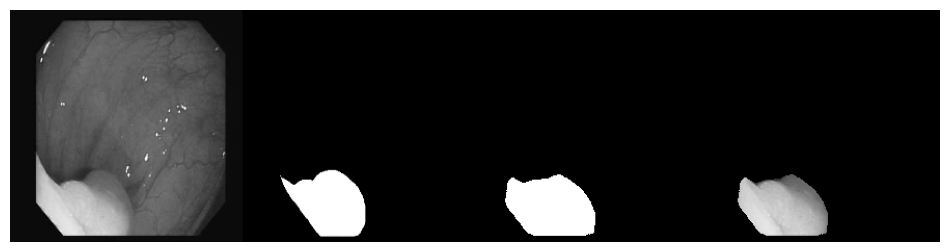

 Epoch: 6 of 100, Iter.: 46 of 46, Train Loss: 0.884065, IoU: 0.391439, Dice: 0.502691
 Epoch: 6 of 100, Iter.: 46 of 46, Valid Loss: 1.008062, IoU: 0.315435, Dice: 0.432841


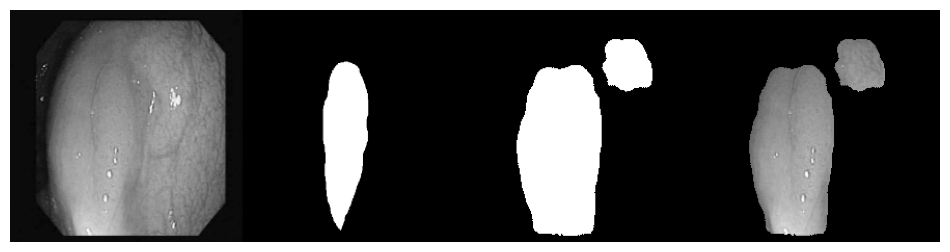

 Epoch: 7 of 100, Iter.: 46 of 46, Train Loss: 0.843075, IoU: 0.432358, Dice: 0.550621
 Epoch: 7 of 100, Iter.: 46 of 46, Valid Loss: 0.908316, IoU: 0.298880, Dice: 0.394844


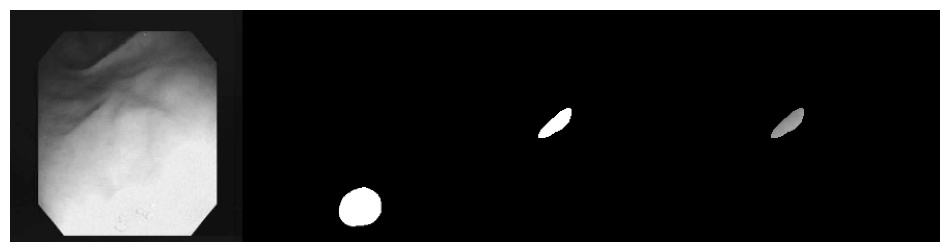

 Epoch: 8 of 100, Iter.: 46 of 46, Train Loss: 0.788499, IoU: 0.445126, Dice: 0.560726
 Epoch: 8 of 100, Iter.: 46 of 46, Valid Loss: 0.870847, IoU: 0.396963, Dice: 0.514467


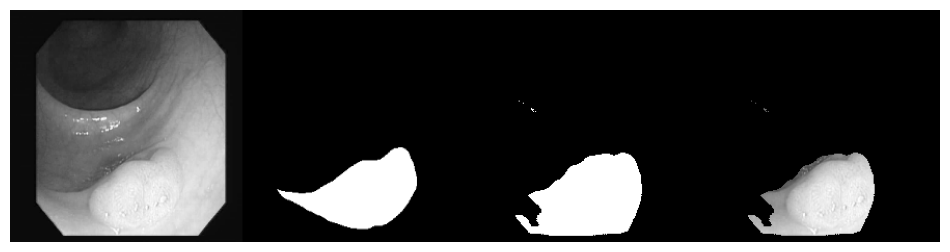

 Epoch: 9 of 100, Iter.: 46 of 46, Train Loss: 0.736205, IoU: 0.492535, Dice: 0.605658
 Epoch: 9 of 100, Iter.: 46 of 46, Valid Loss: 0.777551, IoU: 0.437320, Dice: 0.552055


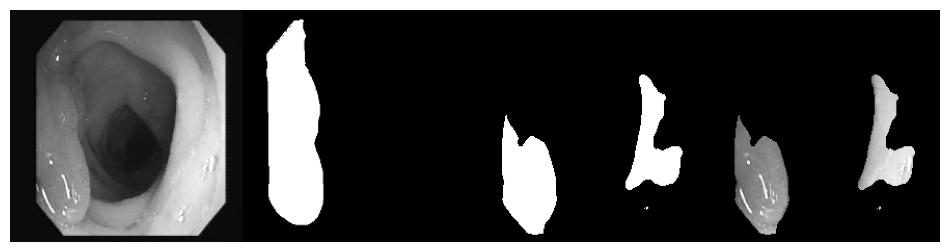

 Epoch: 10 of 100, Iter.: 46 of 46, Train Loss: 0.672321, IoU: 0.544165, Dice: 0.654046
 Epoch: 10 of 100, Iter.: 46 of 46, Valid Loss: 1.029928, IoU: 0.335522, Dice: 0.461152


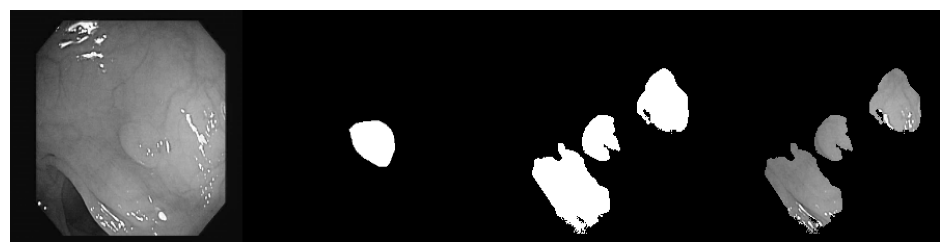

 Epoch: 11 of 100, Iter.: 46 of 46, Train Loss: 0.643564, IoU: 0.559190, Dice: 0.670254
 Epoch: 11 of 100, Iter.: 46 of 46, Valid Loss: 0.703248, IoU: 0.524886, Dice: 0.651240


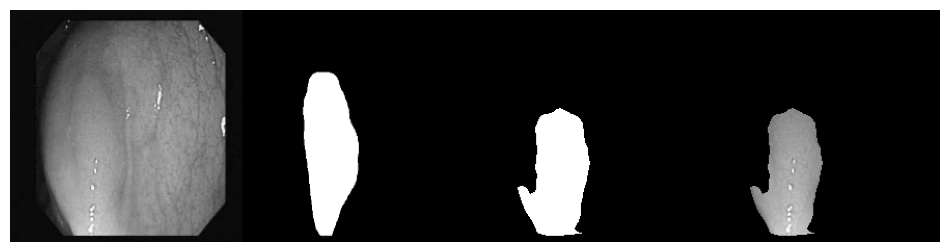

 Epoch: 12 of 100, Iter.: 46 of 46, Train Loss: 0.585615, IoU: 0.598695, Dice: 0.706273
 Epoch: 12 of 100, Iter.: 46 of 46, Valid Loss: 0.752517, IoU: 0.394556, Dice: 0.488138


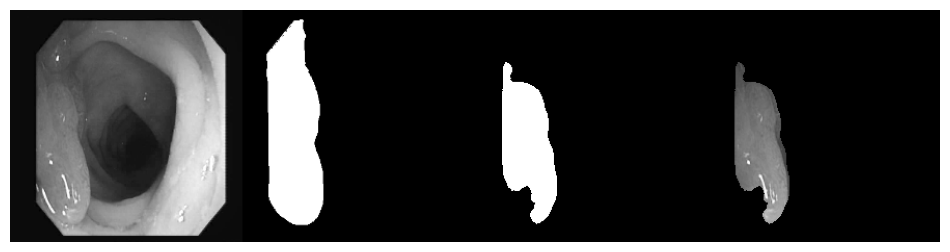

 Epoch: 13 of 100, Iter.: 46 of 46, Train Loss: 0.546595, IoU: 0.612569, Dice: 0.717781
 Epoch: 13 of 100, Iter.: 46 of 46, Valid Loss: 0.623058, IoU: 0.534094, Dice: 0.641822


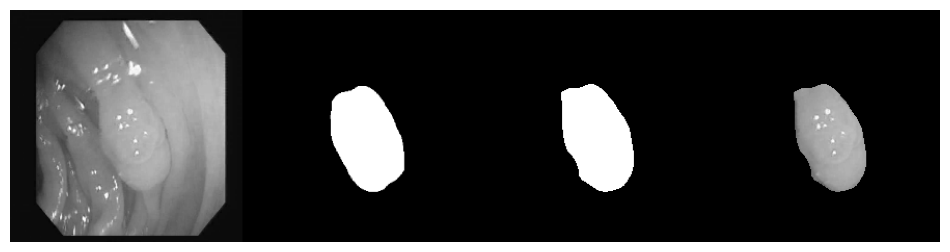

 Epoch: 14 of 100, Iter.: 46 of 46, Train Loss: 0.510616, IoU: 0.627854, Dice: 0.731281
 Epoch: 14 of 100, Iter.: 46 of 46, Valid Loss: 0.655976, IoU: 0.510053, Dice: 0.623746


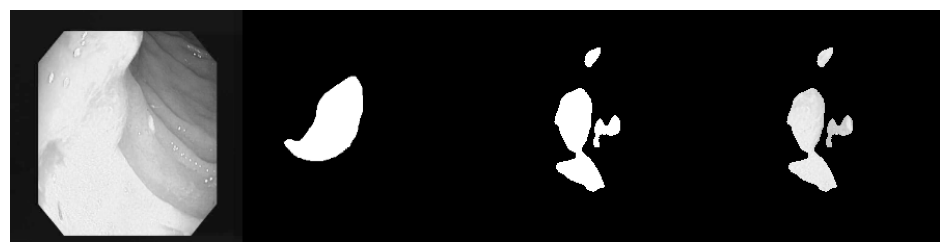

 Epoch: 15 of 100, Iter.: 46 of 46, Train Loss: 0.478903, IoU: 0.649330, Dice: 0.751267
 Epoch: 15 of 100, Iter.: 46 of 46, Valid Loss: 0.553313, IoU: 0.590527, Dice: 0.685920


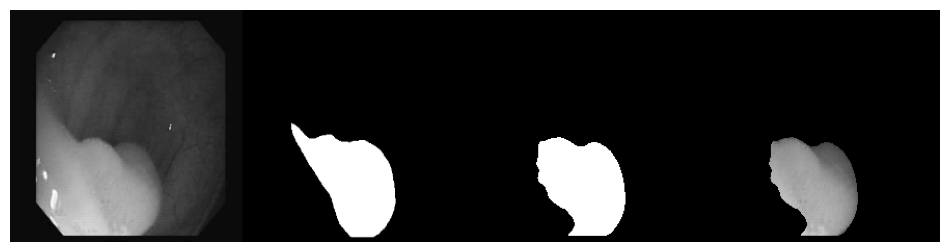

 Epoch: 16 of 100, Iter.: 46 of 46, Train Loss: 0.440791, IoU: 0.673559, Dice: 0.769031
 Epoch: 16 of 100, Iter.: 46 of 46, Valid Loss: 0.584429, IoU: 0.516037, Dice: 0.617661


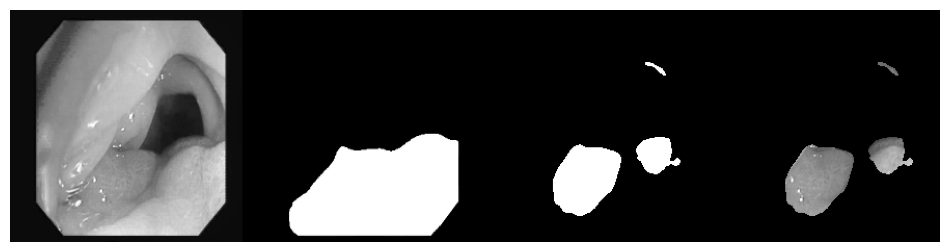

 Epoch: 17 of 100, Iter.: 46 of 46, Train Loss: 0.446984, IoU: 0.655935, Dice: 0.751994
 Epoch: 17 of 100, Iter.: 46 of 46, Valid Loss: 0.582073, IoU: 0.547330, Dice: 0.652662


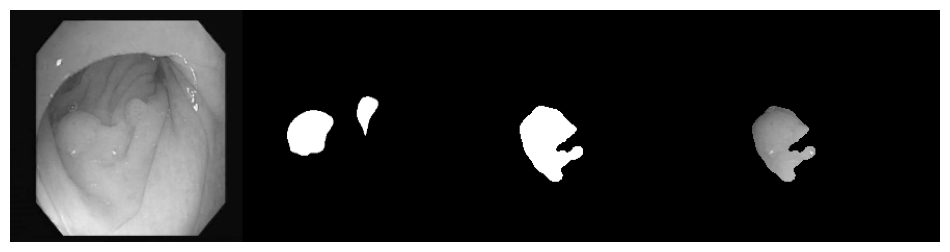

 Epoch: 18 of 100, Iter.: 46 of 46, Train Loss: 0.411423, IoU: 0.674160, Dice: 0.769327
 Epoch: 18 of 100, Iter.: 46 of 46, Valid Loss: 0.551977, IoU: 0.566051, Dice: 0.666388


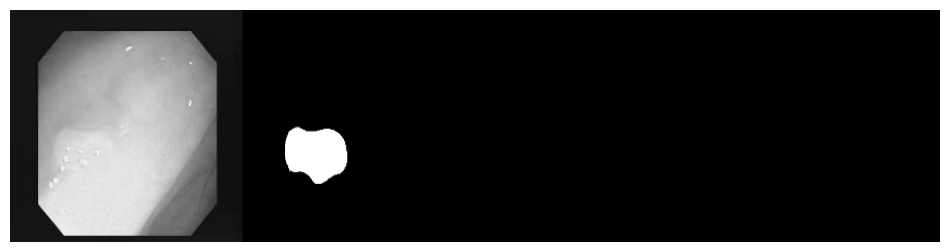

 Epoch: 19 of 100, Iter.: 46 of 46, Train Loss: 0.362190, IoU: 0.718797, Dice: 0.804025
 Epoch: 19 of 100, Iter.: 46 of 46, Valid Loss: 0.651978, IoU: 0.493703, Dice: 0.610576


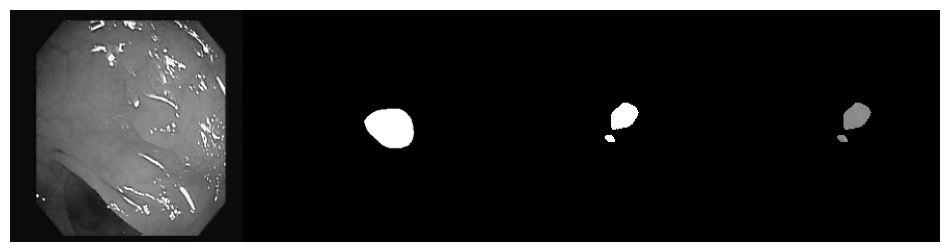

 Epoch: 20 of 100, Iter.: 46 of 46, Train Loss: 0.368129, IoU: 0.688717, Dice: 0.777560
 Epoch: 20 of 100, Iter.: 46 of 46, Valid Loss: 0.494016, IoU: 0.573142, Dice: 0.664474


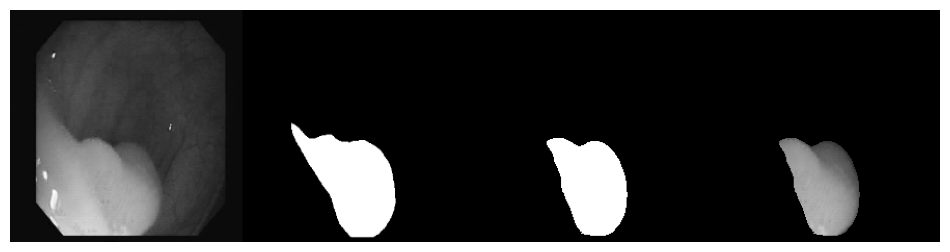

 Epoch: 21 of 100, Iter.: 46 of 46, Train Loss: 0.331202, IoU: 0.730583, Dice: 0.812361
 Epoch: 21 of 100, Iter.: 46 of 46, Valid Loss: 0.460156, IoU: 0.607848, Dice: 0.707975


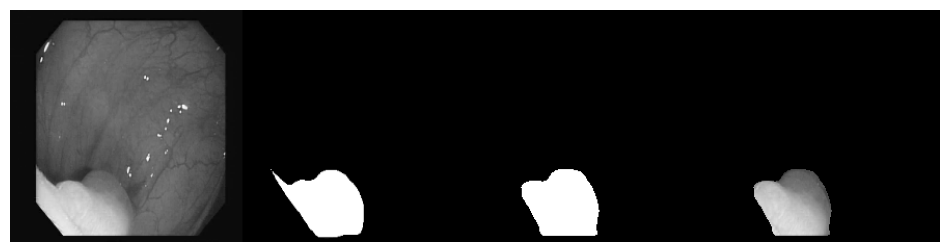

 Epoch: 22 of 100, Iter.: 46 of 46, Train Loss: 0.304376, IoU: 0.750404, Dice: 0.828282
 Epoch: 22 of 100, Iter.: 46 of 46, Valid Loss: 0.446666, IoU: 0.606827, Dice: 0.697990


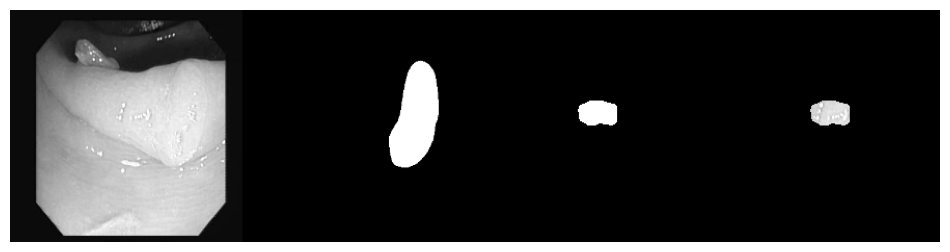

 Epoch: 23 of 100, Iter.: 46 of 46, Train Loss: 0.288049, IoU: 0.751045, Dice: 0.828166
 Epoch: 23 of 100, Iter.: 46 of 46, Valid Loss: 0.535634, IoU: 0.539116, Dice: 0.623916


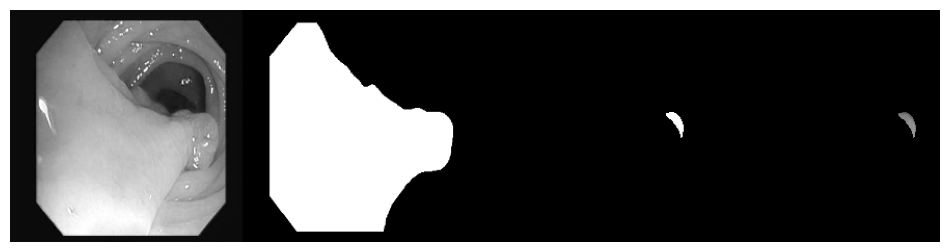

 Epoch: 24 of 100, Iter.: 46 of 46, Train Loss: 0.256982, IoU: 0.771882, Dice: 0.843409
 Epoch: 24 of 100, Iter.: 46 of 46, Valid Loss: 0.509468, IoU: 0.549147, Dice: 0.653636


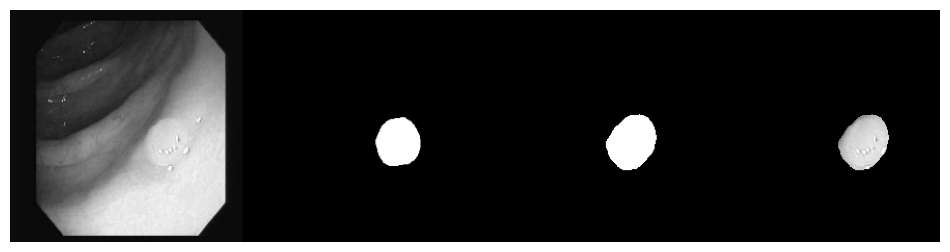

 Epoch: 25 of 100, Iter.: 46 of 46, Train Loss: 0.256248, IoU: 0.764831, Dice: 0.838045
 Epoch: 25 of 100, Iter.: 46 of 46, Valid Loss: 0.383023, IoU: 0.647938, Dice: 0.736222


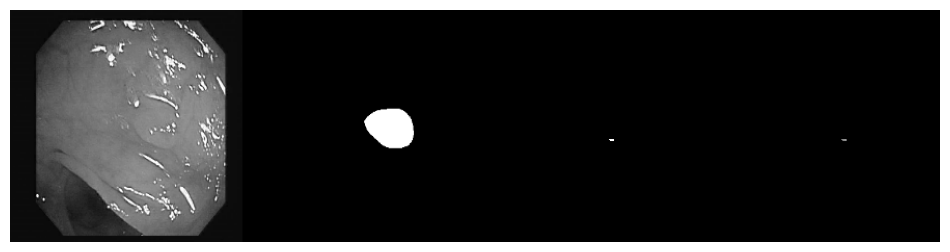

 Epoch: 26 of 100, Iter.: 46 of 46, Train Loss: 0.237553, IoU: 0.781058, Dice: 0.853419
 Epoch: 26 of 100, Iter.: 46 of 46, Valid Loss: 0.427734, IoU: 0.601582, Dice: 0.703183


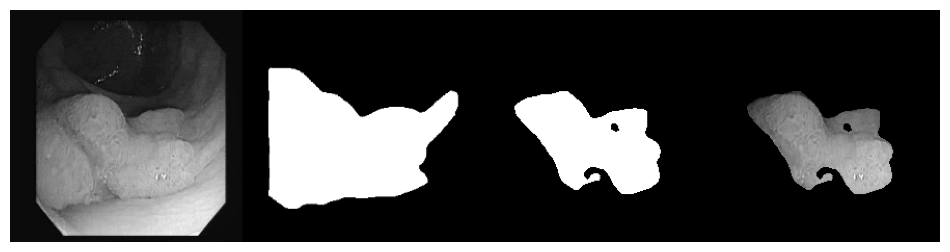

 Epoch: 27 of 100, Iter.: 46 of 46, Train Loss: 0.216850, IoU: 0.802643, Dice: 0.867390
 Epoch: 27 of 100, Iter.: 46 of 46, Valid Loss: 0.441436, IoU: 0.573086, Dice: 0.657539


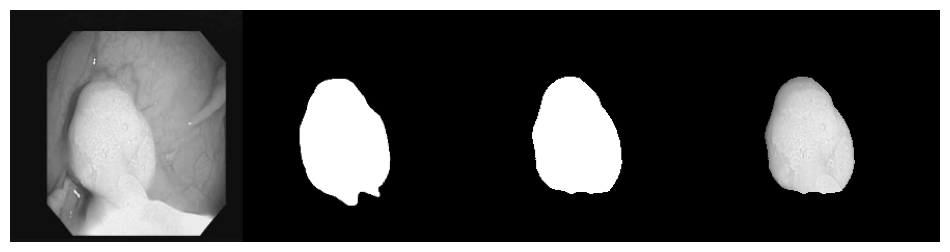

 Epoch: 28 of 100, Iter.: 46 of 46, Train Loss: 0.205399, IoU: 0.805321, Dice: 0.868575
 Epoch: 28 of 100, Iter.: 46 of 46, Valid Loss: 0.445859, IoU: 0.630158, Dice: 0.728305


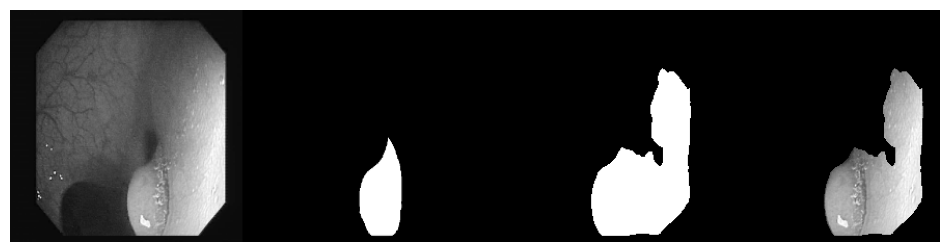

 Epoch: 29 of 100, Iter.: 46 of 46, Train Loss: 0.196576, IoU: 0.813125, Dice: 0.875162
 Epoch: 29 of 100, Iter.: 46 of 46, Valid Loss: 0.520680, IoU: 0.499058, Dice: 0.579846


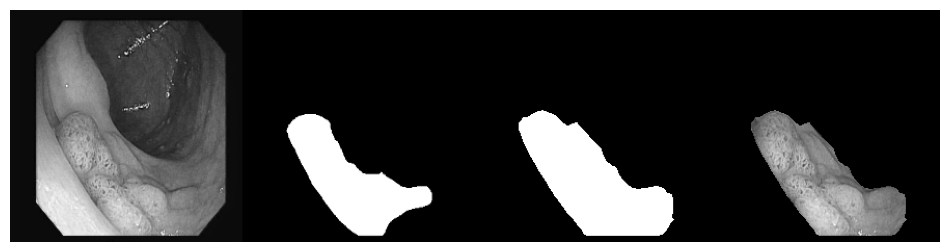

 Epoch: 30 of 100, Iter.: 46 of 46, Train Loss: 0.197168, IoU: 0.809368, Dice: 0.874398
 Epoch: 30 of 100, Iter.: 46 of 46, Valid Loss: 0.356522, IoU: 0.673740, Dice: 0.758088


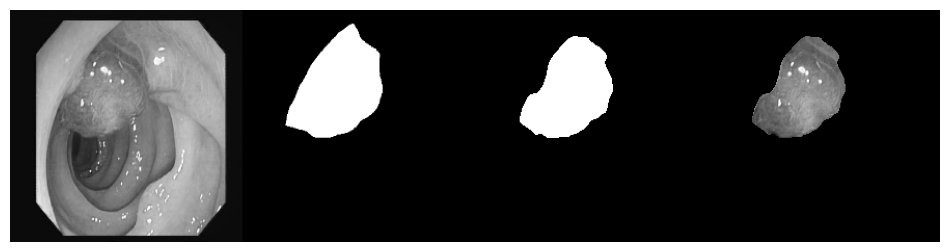

 Epoch: 31 of 100, Iter.: 46 of 46, Train Loss: 0.171104, IoU: 0.830407, Dice: 0.889786
 Epoch: 31 of 100, Iter.: 46 of 46, Valid Loss: 0.391402, IoU: 0.623867, Dice: 0.709820


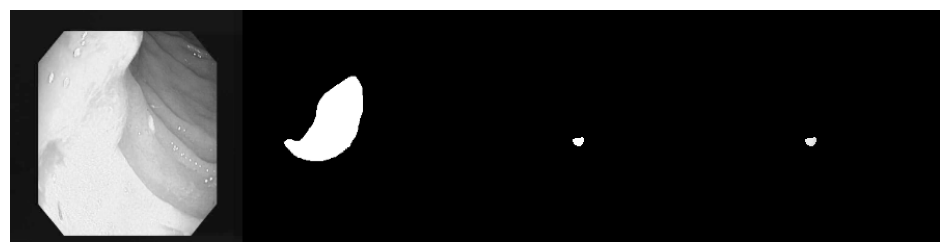

 Epoch: 32 of 100, Iter.: 46 of 46, Train Loss: 0.159656, IoU: 0.845476, Dice: 0.899246
 Epoch: 32 of 100, Iter.: 46 of 46, Valid Loss: 0.444906, IoU: 0.598086, Dice: 0.700367


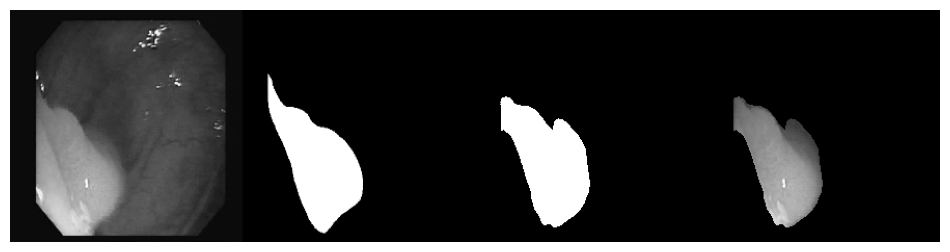

 Epoch: 33 of 100, Iter.: 46 of 46, Train Loss: 0.166379, IoU: 0.828426, Dice: 0.887616
 Epoch: 33 of 100, Iter.: 46 of 46, Valid Loss: 0.380298, IoU: 0.628286, Dice: 0.716575


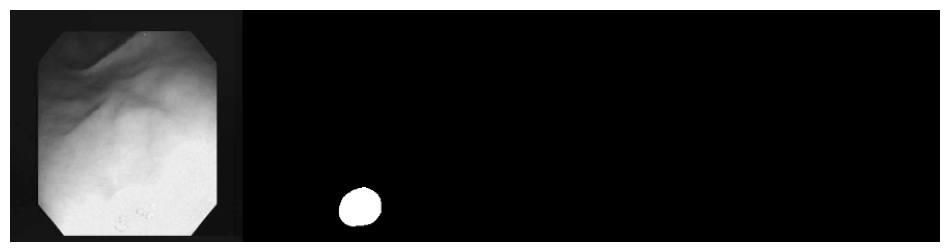

 Epoch: 34 of 100, Iter.: 46 of 46, Train Loss: 0.156913, IoU: 0.835283, Dice: 0.892552
 Epoch: 34 of 100, Iter.: 46 of 46, Valid Loss: 0.393586, IoU: 0.609758, Dice: 0.694742


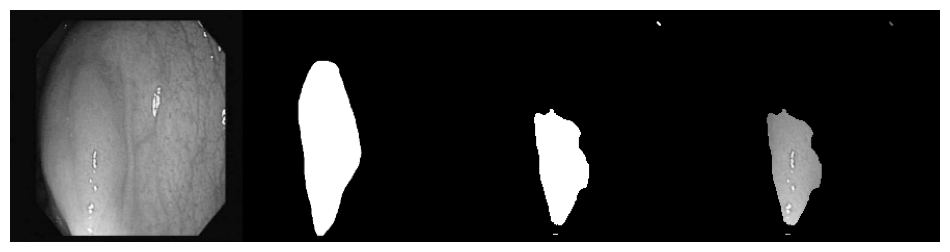

 Epoch: 35 of 100, Iter.: 46 of 46, Train Loss: 0.153947, IoU: 0.834348, Dice: 0.890594
 Epoch: 35 of 100, Iter.: 46 of 46, Valid Loss: 0.408318, IoU: 0.608377, Dice: 0.690778


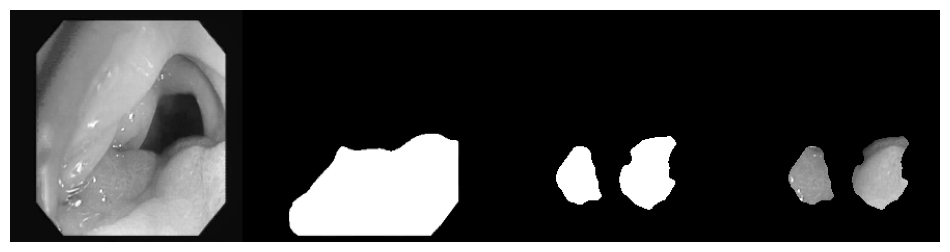

 Epoch: 36 of 100, Iter.: 46 of 46, Train Loss: 0.170147, IoU: 0.811864, Dice: 0.872755
 Epoch: 36 of 100, Iter.: 46 of 46, Valid Loss: 0.436269, IoU: 0.566033, Dice: 0.659349


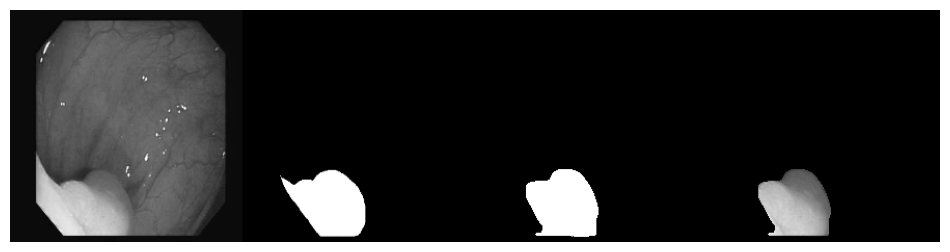

 Epoch: 37 of 100, Iter.: 46 of 46, Train Loss: 0.139824, IoU: 0.841994, Dice: 0.896203
 Epoch: 37 of 100, Iter.: 46 of 46, Valid Loss: 0.387979, IoU: 0.647408, Dice: 0.729139


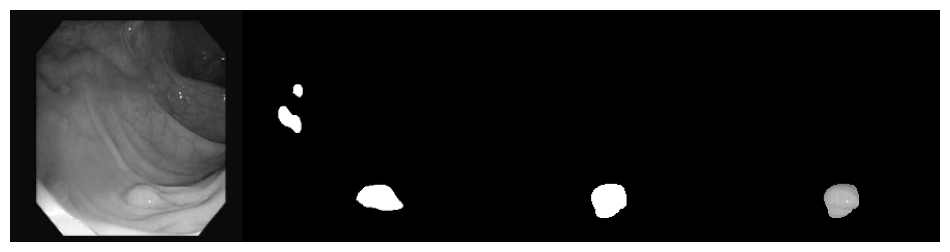

 Epoch: 38 of 100, Iter.: 46 of 46, Train Loss: 0.120756, IoU: 0.863731, Dice: 0.911486
 Epoch: 38 of 100, Iter.: 46 of 46, Valid Loss: 0.330754, IoU: 0.677918, Dice: 0.754385


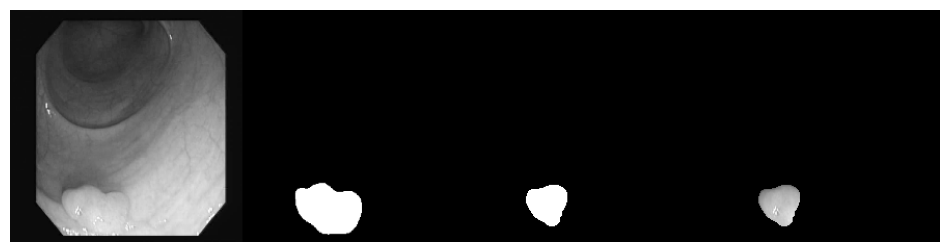

 Epoch: 39 of 100, Iter.: 46 of 46, Train Loss: 0.112854, IoU: 0.876123, Dice: 0.919131
 Epoch: 39 of 100, Iter.: 46 of 46, Valid Loss: 0.356381, IoU: 0.659326, Dice: 0.744192


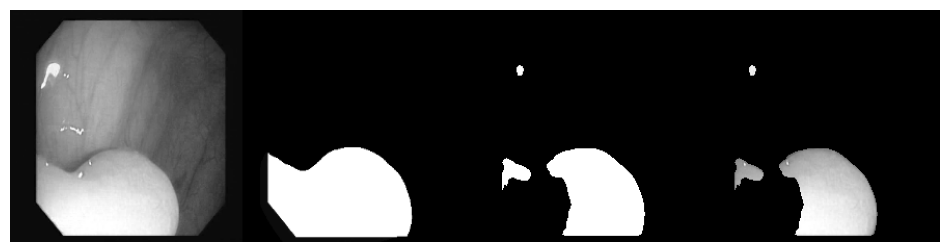

 Epoch: 40 of 100, Iter.: 46 of 46, Train Loss: 0.106093, IoU: 0.880842, Dice: 0.922469
 Epoch: 40 of 100, Iter.: 46 of 46, Valid Loss: 0.330959, IoU: 0.681968, Dice: 0.758236


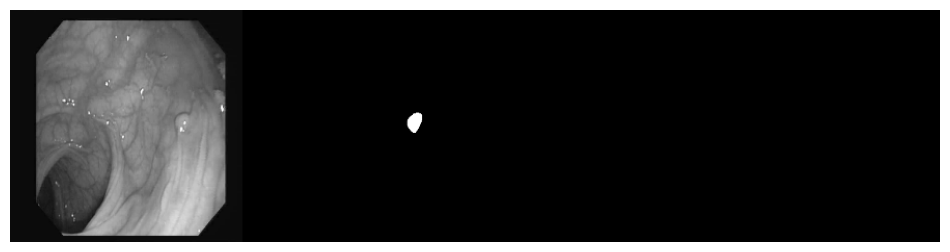

 Epoch: 41 of 100, Iter.: 46 of 46, Train Loss: 0.098258, IoU: 0.884798, Dice: 0.924881
 Epoch: 41 of 100, Iter.: 46 of 46, Valid Loss: 0.320941, IoU: 0.690525, Dice: 0.769382


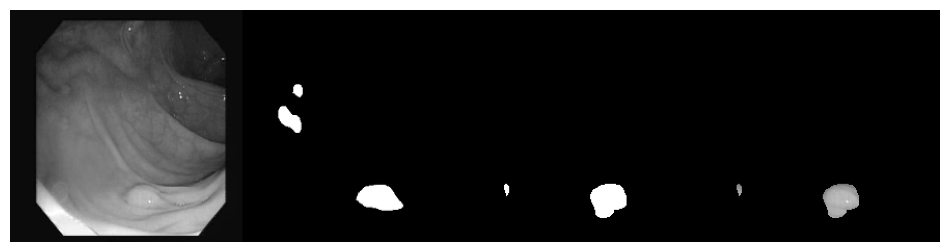

 Epoch: 42 of 100, Iter.: 46 of 46, Train Loss: 0.092957, IoU: 0.888518, Dice: 0.927478
 Epoch: 42 of 100, Iter.: 46 of 46, Valid Loss: 0.310796, IoU: 0.694062, Dice: 0.769146


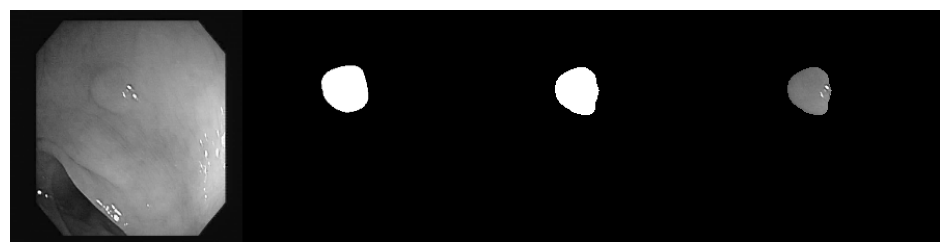

 Epoch: 43 of 100, Iter.: 46 of 46, Train Loss: 0.088222, IoU: 0.894977, Dice: 0.932006
 Epoch: 43 of 100, Iter.: 46 of 46, Valid Loss: 0.314912, IoU: 0.688480, Dice: 0.763363


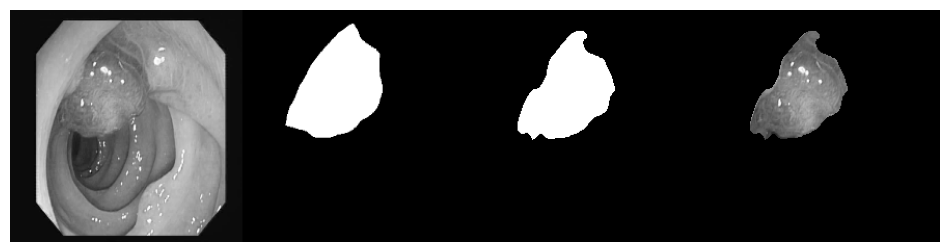

 Epoch: 44 of 100, Iter.: 46 of 46, Train Loss: 0.088989, IoU: 0.897133, Dice: 0.933495
 Epoch: 44 of 100, Iter.: 46 of 46, Valid Loss: 0.338507, IoU: 0.676772, Dice: 0.753042


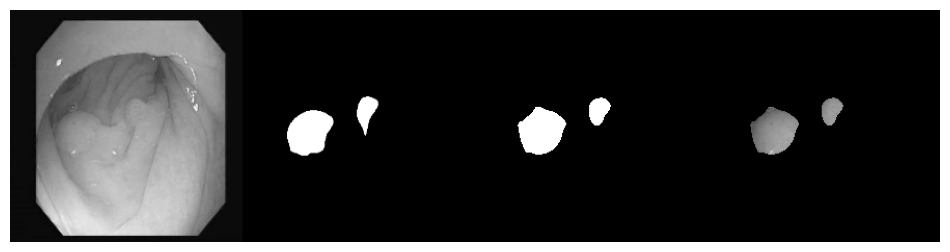

 Epoch: 45 of 100, Iter.: 46 of 46, Train Loss: 0.083381, IoU: 0.899315, Dice: 0.935948
 Epoch: 45 of 100, Iter.: 46 of 46, Valid Loss: 0.311592, IoU: 0.692715, Dice: 0.769239


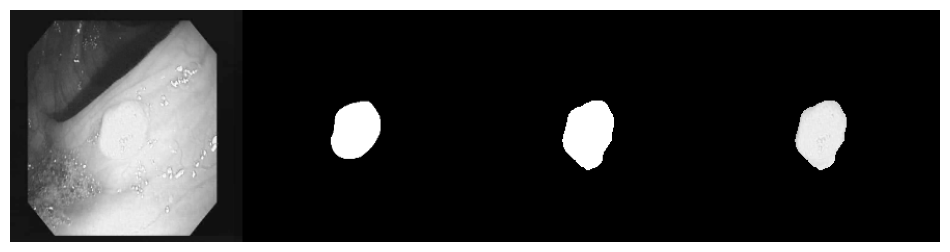

 Epoch: 46 of 100, Iter.: 46 of 46, Train Loss: 0.082547, IoU: 0.900708, Dice: 0.936114
 Epoch: 46 of 100, Iter.: 46 of 46, Valid Loss: 0.327919, IoU: 0.675238, Dice: 0.753298


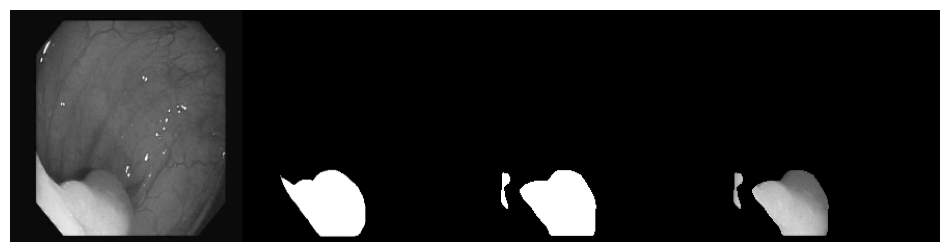

 Epoch: 47 of 100, Iter.: 46 of 46, Train Loss: 0.080890, IoU: 0.900016, Dice: 0.936419
 Epoch: 47 of 100, Iter.: 46 of 46, Valid Loss: 0.325052, IoU: 0.681113, Dice: 0.756294


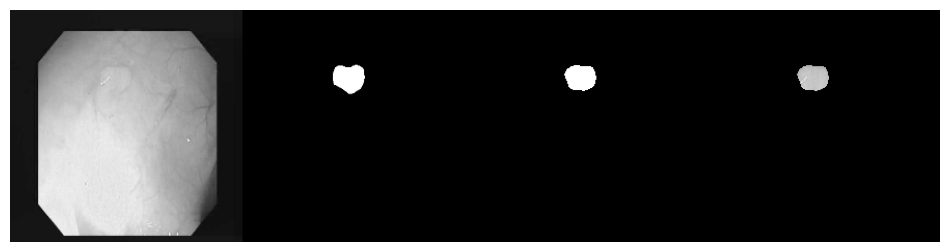

 Epoch: 48 of 100, Iter.: 46 of 46, Train Loss: 0.080638, IoU: 0.897382, Dice: 0.935147
 Epoch: 48 of 100, Iter.: 46 of 46, Valid Loss: 0.333614, IoU: 0.668476, Dice: 0.748240


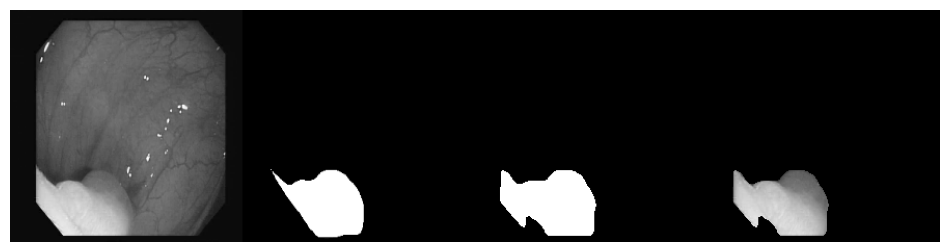

 Epoch: 49 of 100, Iter.: 46 of 46, Train Loss: 0.079402, IoU: 0.900389, Dice: 0.937851
 Epoch: 49 of 100, Iter.: 46 of 46, Valid Loss: 0.312068, IoU: 0.687964, Dice: 0.766762


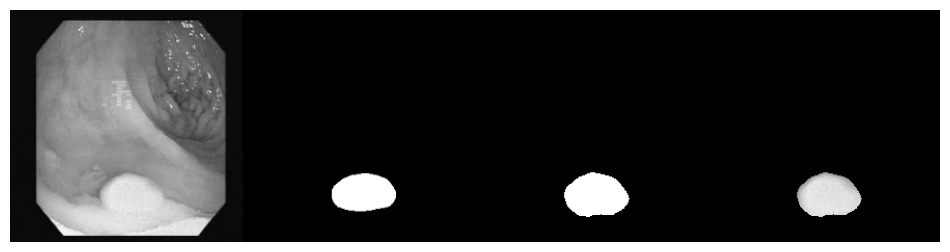

 Epoch: 50 of 100, Iter.: 46 of 46, Train Loss: 0.074642, IoU: 0.905411, Dice: 0.940323
 Epoch: 50 of 100, Iter.: 46 of 46, Valid Loss: 0.332309, IoU: 0.679079, Dice: 0.757665


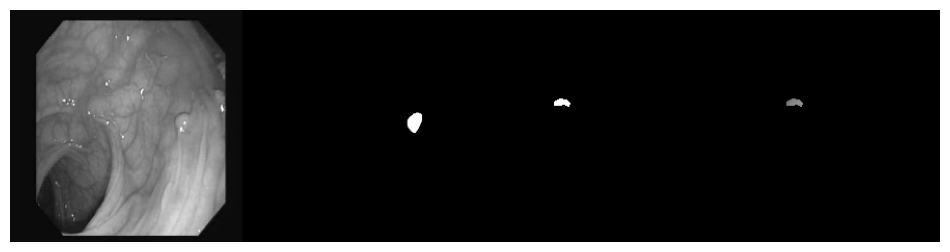

 Epoch: 51 of 100, Iter.: 46 of 46, Train Loss: 0.077228, IoU: 0.903303, Dice: 0.940196
 Epoch: 51 of 100, Iter.: 46 of 46, Valid Loss: 0.346190, IoU: 0.653151, Dice: 0.732339


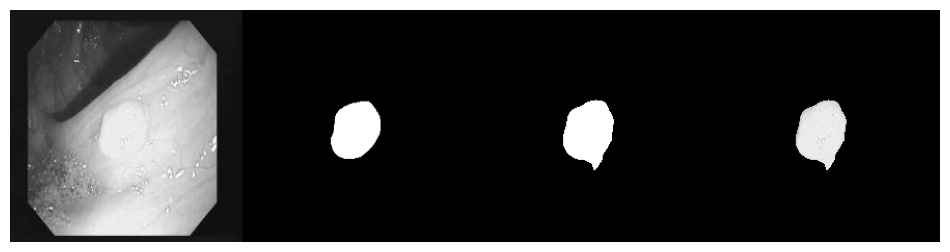

 Epoch: 52 of 100, Iter.: 46 of 46, Train Loss: 0.069579, IoU: 0.910923, Dice: 0.943755
 Epoch: 52 of 100, Iter.: 46 of 46, Valid Loss: 0.381313, IoU: 0.639577, Dice: 0.716692


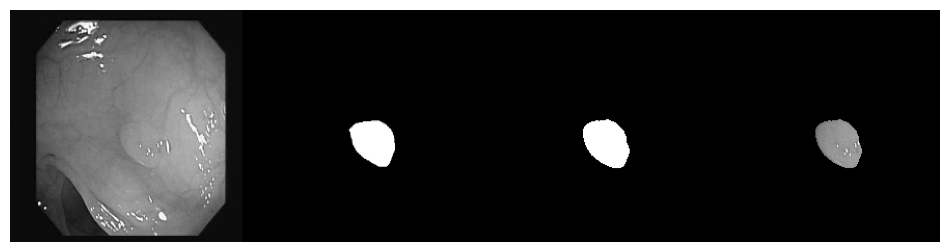

 Epoch: 53 of 100, Iter.: 46 of 46, Train Loss: 0.071568, IoU: 0.907281, Dice: 0.942145
 Epoch: 53 of 100, Iter.: 46 of 46, Valid Loss: 0.315905, IoU: 0.674521, Dice: 0.750813


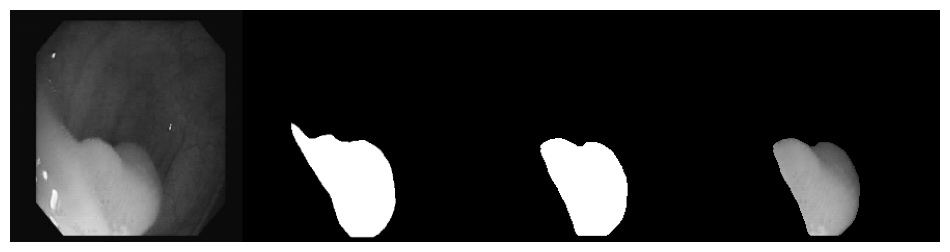

 Epoch: 54 of 100, Iter.: 46 of 46, Train Loss: 0.068215, IoU: 0.910612, Dice: 0.942920
 Epoch: 54 of 100, Iter.: 46 of 46, Valid Loss: 0.329895, IoU: 0.680757, Dice: 0.757277


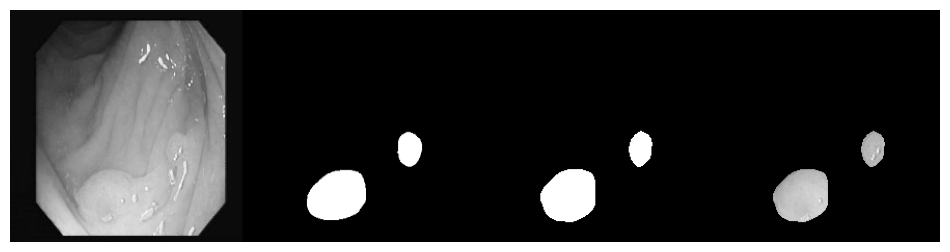

 Epoch: 55 of 100, Iter.: 46 of 46, Train Loss: 0.064068, IoU: 0.916486, Dice: 0.947299
 Epoch: 55 of 100, Iter.: 46 of 46, Valid Loss: 0.308372, IoU: 0.696570, Dice: 0.775490


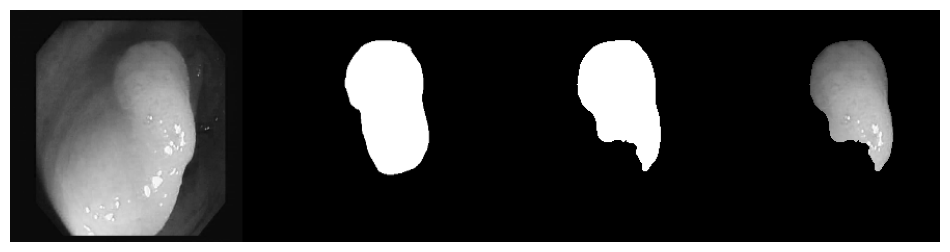

 Epoch: 56 of 100, Iter.: 46 of 46, Train Loss: 0.063854, IoU: 0.917363, Dice: 0.948613
 Epoch: 56 of 100, Iter.: 46 of 46, Valid Loss: 0.320174, IoU: 0.678772, Dice: 0.755708


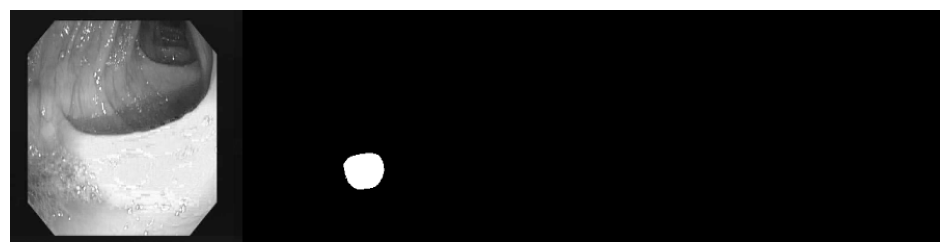

 Epoch: 57 of 100, Iter.: 46 of 46, Train Loss: 0.057544, IoU: 0.922560, Dice: 0.951720
 Epoch: 57 of 100, Iter.: 46 of 46, Valid Loss: 0.295722, IoU: 0.700025, Dice: 0.775524


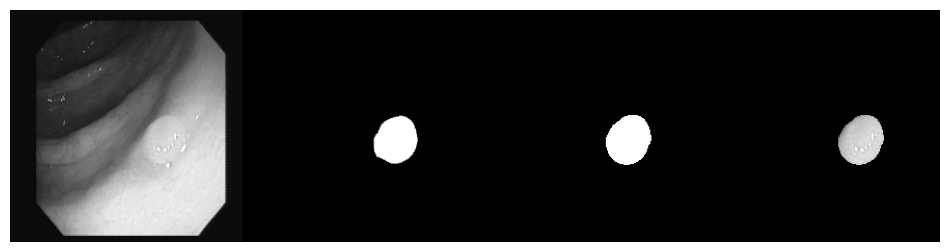

 Epoch: 58 of 100, Iter.: 46 of 46, Train Loss: 0.056183, IoU: 0.925271, Dice: 0.953633
 Epoch: 58 of 100, Iter.: 46 of 46, Valid Loss: 0.339641, IoU: 0.679232, Dice: 0.755984


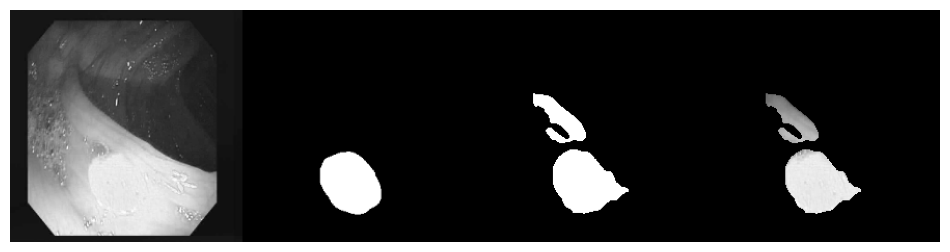

 Epoch: 59 of 100, Iter.: 46 of 46, Train Loss: 0.055307, IoU: 0.925856, Dice: 0.954306
 Epoch: 59 of 100, Iter.: 46 of 46, Valid Loss: 0.346495, IoU: 0.650437, Dice: 0.725637


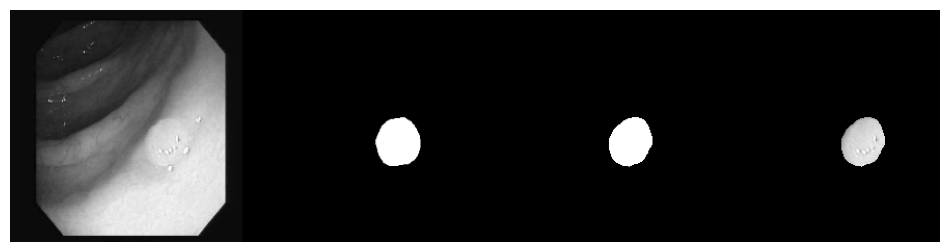

 Epoch: 60 of 100, Iter.: 46 of 46, Train Loss: 0.059683, IoU: 0.919464, Dice: 0.951426
 Epoch: 60 of 100, Iter.: 46 of 46, Valid Loss: 0.312065, IoU: 0.682301, Dice: 0.763917


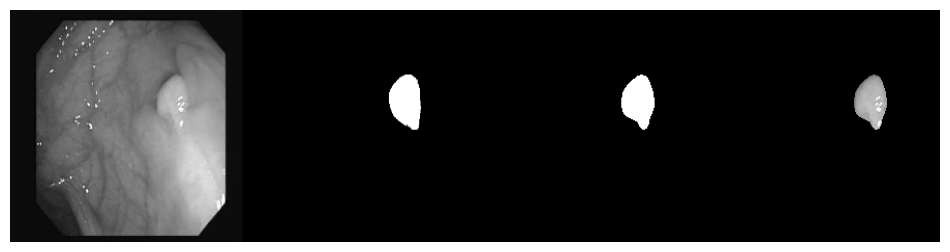

 Epoch: 61 of 100, Iter.: 46 of 46, Train Loss: 0.058880, IoU: 0.921572, Dice: 0.952739
 Epoch: 61 of 100, Iter.: 46 of 46, Valid Loss: 0.314291, IoU: 0.684252, Dice: 0.756862


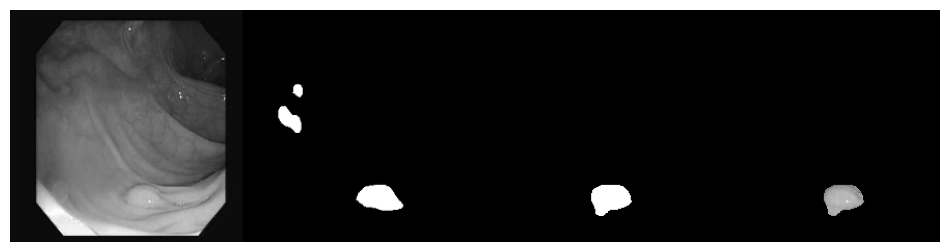

 Epoch: 62 of 100, Iter.: 46 of 46, Train Loss: 0.055353, IoU: 0.927600, Dice: 0.956930
 Epoch: 62 of 100, Iter.: 46 of 46, Valid Loss: 0.316667, IoU: 0.695072, Dice: 0.772960


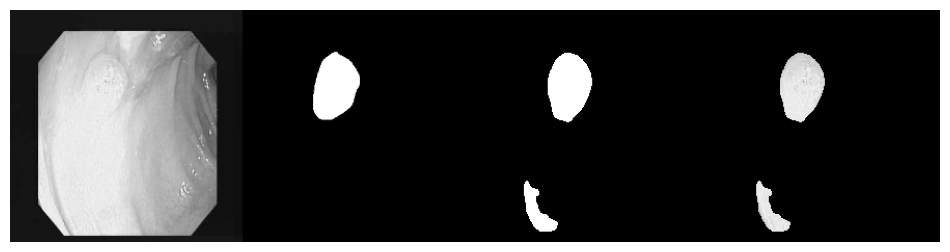

 Epoch: 63 of 100, Iter.: 46 of 46, Train Loss: 0.051484, IoU: 0.930482, Dice: 0.959099
 Epoch: 63 of 100, Iter.: 46 of 46, Valid Loss: 0.303824, IoU: 0.692396, Dice: 0.767162


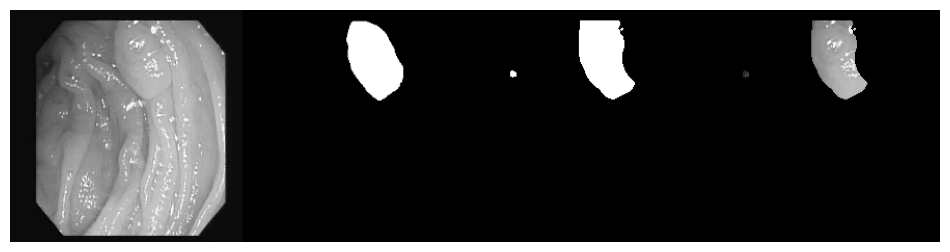

 Epoch: 64 of 100, Iter.: 46 of 46, Train Loss: 0.047914, IoU: 0.937081, Dice: 0.962938
 Epoch: 64 of 100, Iter.: 46 of 46, Valid Loss: 0.348216, IoU: 0.673185, Dice: 0.747028


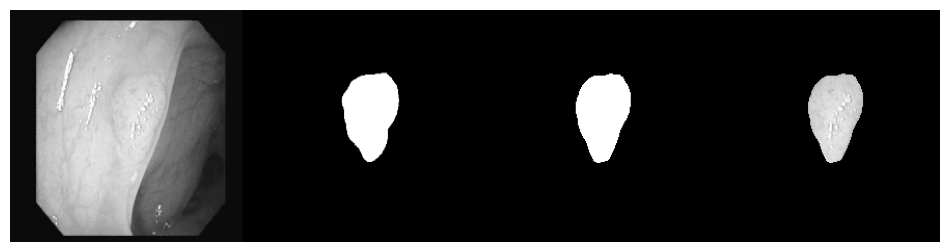

 Epoch: 65 of 100, Iter.: 46 of 46, Train Loss: 0.046890, IoU: 0.937543, Dice: 0.963310
 Epoch: 65 of 100, Iter.: 46 of 46, Valid Loss: 0.327425, IoU: 0.679450, Dice: 0.756047


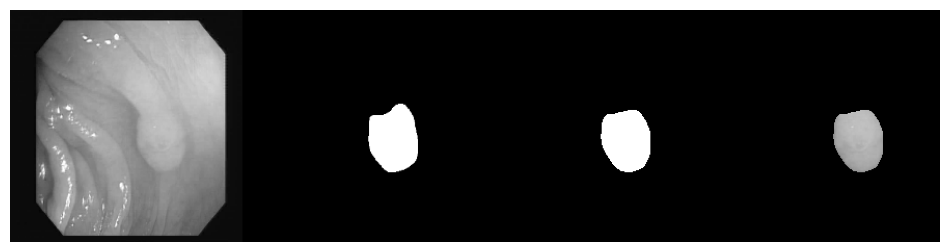

 Epoch: 66 of 100, Iter.: 46 of 46, Train Loss: 0.045535, IoU: 0.939477, Dice: 0.964285
 Epoch: 66 of 100, Iter.: 46 of 46, Valid Loss: 0.313497, IoU: 0.689927, Dice: 0.766883


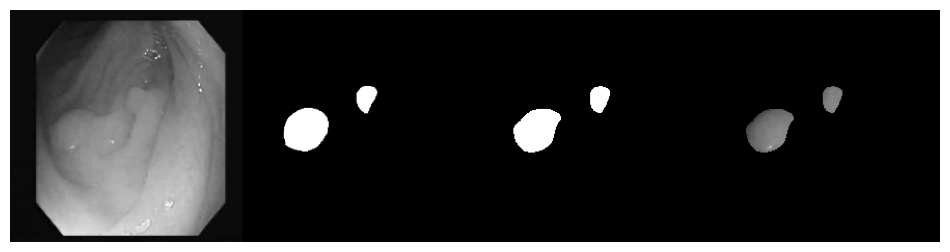

 Epoch: 67 of 100, Iter.: 46 of 46, Train Loss: 0.044493, IoU: 0.941172, Dice: 0.965848
 Epoch: 67 of 100, Iter.: 46 of 46, Valid Loss: 0.325164, IoU: 0.691862, Dice: 0.768396


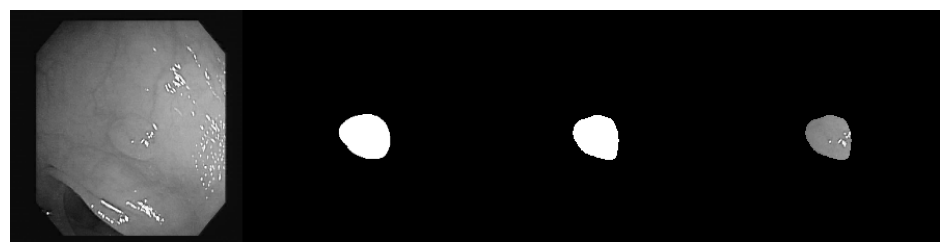

 Epoch: 68 of 100, Iter.: 46 of 46, Train Loss: 0.042438, IoU: 0.943254, Dice: 0.967321
 Epoch: 68 of 100, Iter.: 46 of 46, Valid Loss: 0.302454, IoU: 0.702487, Dice: 0.777159


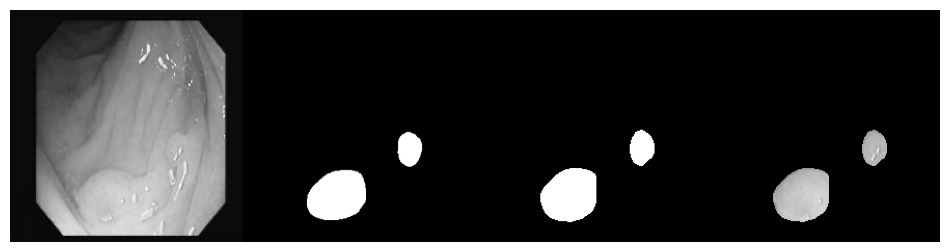

 Epoch: 69 of 100, Iter.: 46 of 46, Train Loss: 0.047664, IoU: 0.936158, Dice: 0.962712
 Epoch: 69 of 100, Iter.: 46 of 46, Valid Loss: 0.352641, IoU: 0.680767, Dice: 0.764018


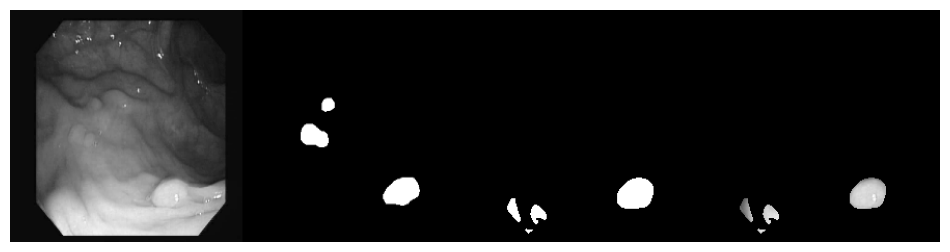

 Epoch: 70 of 100, Iter.: 46 of 46, Train Loss: 0.139195, IoU: 0.831747, Dice: 0.888079
 Epoch: 70 of 100, Iter.: 46 of 46, Valid Loss: 0.895265, IoU: 0.487857, Dice: 0.605758


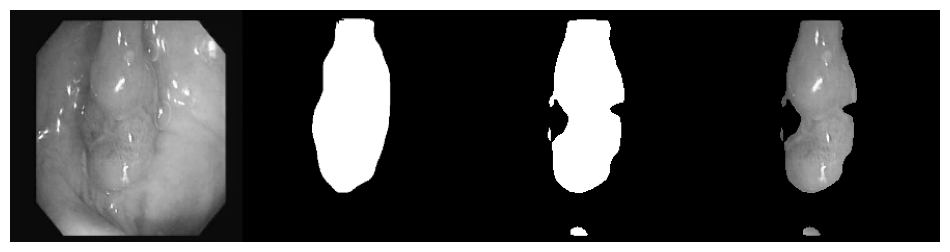

 Epoch: 71 of 100, Iter.: 46 of 46, Train Loss: 0.228215, IoU: 0.748640, Dice: 0.828520
 Epoch: 71 of 100, Iter.: 46 of 46, Valid Loss: 0.514317, IoU: 0.532468, Dice: 0.637648


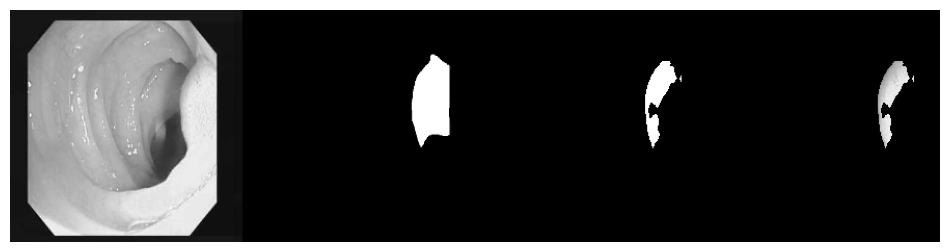

 Epoch: 72 of 100, Iter.: 46 of 46, Train Loss: 0.188511, IoU: 0.778402, Dice: 0.852875
 Epoch: 72 of 100, Iter.: 46 of 46, Valid Loss: 0.358136, IoU: 0.640897, Dice: 0.732318


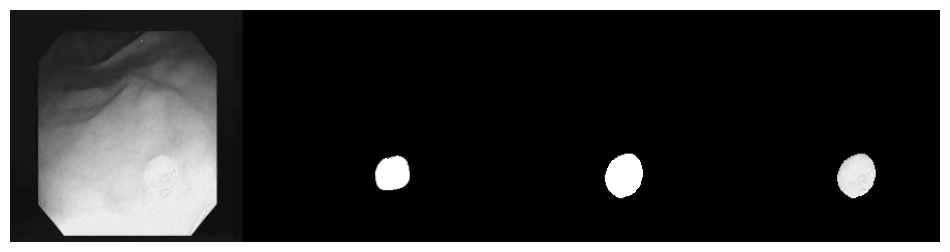

 Epoch: 73 of 100, Iter.: 46 of 46, Train Loss: 0.156168, IoU: 0.813663, Dice: 0.877567
 Epoch: 73 of 100, Iter.: 46 of 46, Valid Loss: 0.668782, IoU: 0.401287, Dice: 0.481108


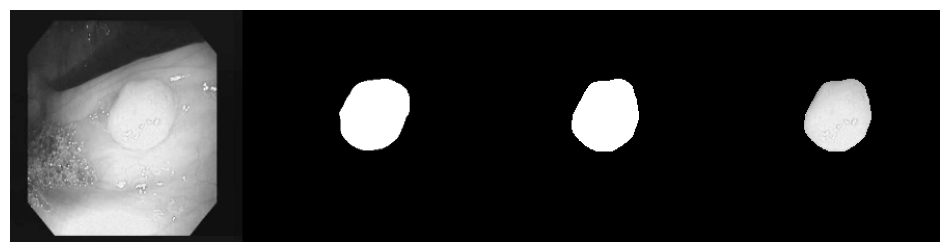

 Epoch: 74 of 100, Iter.: 46 of 46, Train Loss: 0.120448, IoU: 0.848471, Dice: 0.903514
 Epoch: 74 of 100, Iter.: 46 of 46, Valid Loss: 0.345596, IoU: 0.617074, Dice: 0.705867


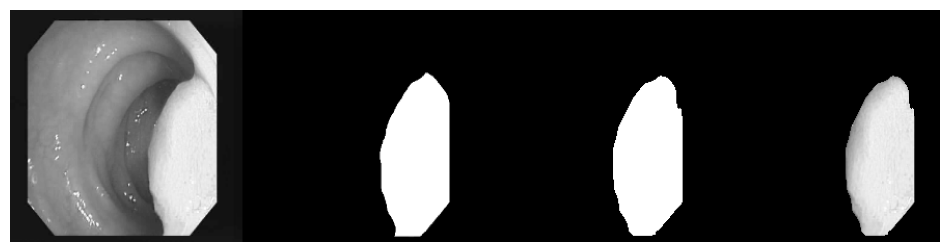

 Epoch: 75 of 100, Iter.: 46 of 46, Train Loss: 0.085128, IoU: 0.876135, Dice: 0.923785
 Epoch: 75 of 100, Iter.: 46 of 46, Valid Loss: 0.353436, IoU: 0.657455, Dice: 0.733992


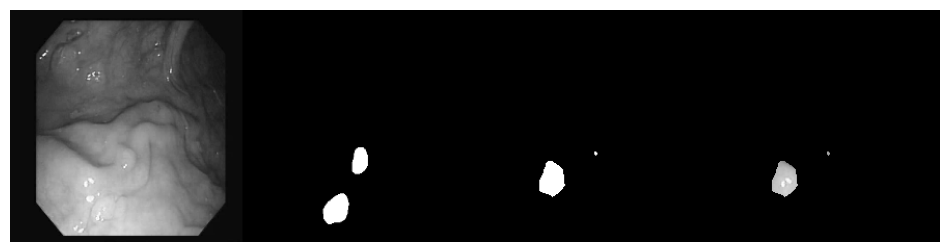

 Epoch: 76 of 100, Iter.: 46 of 46, Train Loss: 0.065365, IoU: 0.904648, Dice: 0.941803
 Epoch: 76 of 100, Iter.: 46 of 46, Valid Loss: 0.328282, IoU: 0.675988, Dice: 0.753411


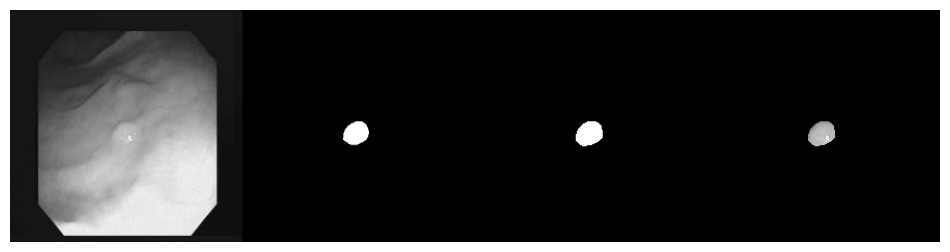

 Epoch: 77 of 100, Iter.: 46 of 46, Train Loss: 0.053329, IoU: 0.921791, Dice: 0.953671
 Epoch: 77 of 100, Iter.: 46 of 46, Valid Loss: 0.313030, IoU: 0.690327, Dice: 0.763197


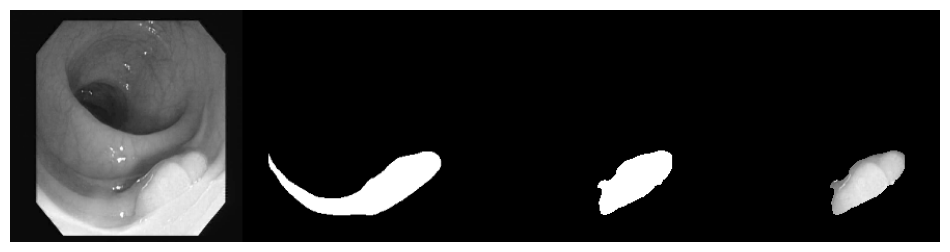

 Epoch: 78 of 100, Iter.: 46 of 46, Train Loss: 0.048434, IoU: 0.932089, Dice: 0.961336
 Epoch: 78 of 100, Iter.: 46 of 46, Valid Loss: 0.321556, IoU: 0.686198, Dice: 0.758507


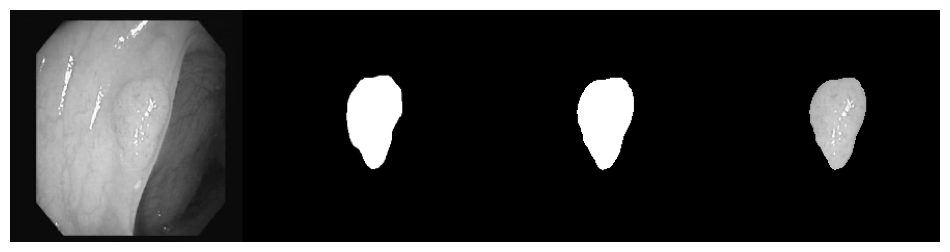

 Epoch: 79 of 100, Iter.: 46 of 46, Train Loss: 0.044465, IoU: 0.937968, Dice: 0.964336
 Epoch: 79 of 100, Iter.: 46 of 46, Valid Loss: 0.321014, IoU: 0.687235, Dice: 0.758081


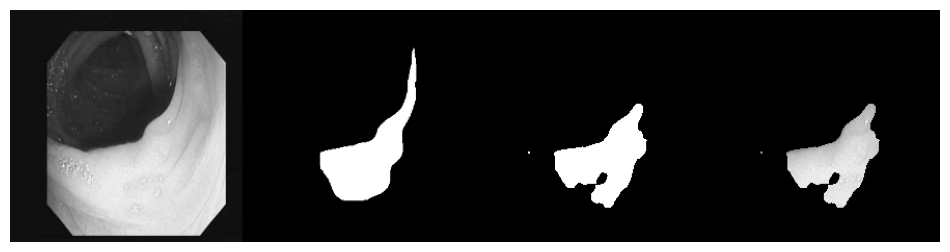

 Epoch: 80 of 100, Iter.: 46 of 46, Train Loss: 0.041539, IoU: 0.942163, Dice: 0.966928
 Epoch: 80 of 100, Iter.: 46 of 46, Valid Loss: 0.321929, IoU: 0.690643, Dice: 0.760306


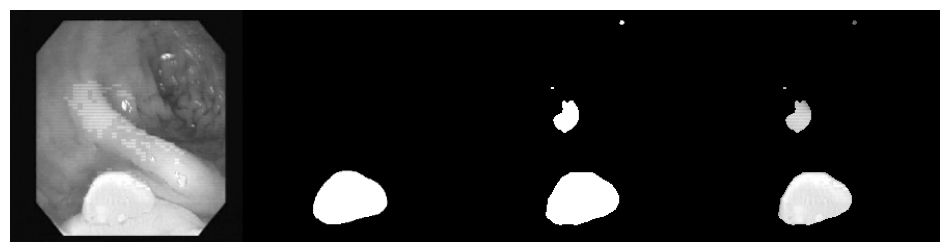

 Epoch: 81 of 100, Iter.: 46 of 46, Train Loss: 0.038704, IoU: 0.945071, Dice: 0.968875
 Epoch: 81 of 100, Iter.: 46 of 46, Valid Loss: 0.329032, IoU: 0.683561, Dice: 0.756739


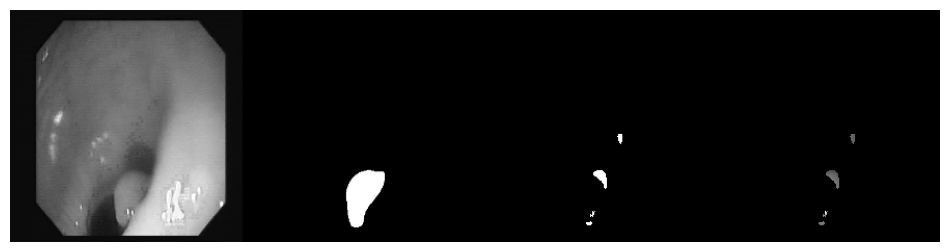

 Epoch: 82 of 100, Iter.: 46 of 46, Train Loss: 0.038016, IoU: 0.945640, Dice: 0.969260
 Epoch: 82 of 100, Iter.: 46 of 46, Valid Loss: 0.312684, IoU: 0.701416, Dice: 0.772415


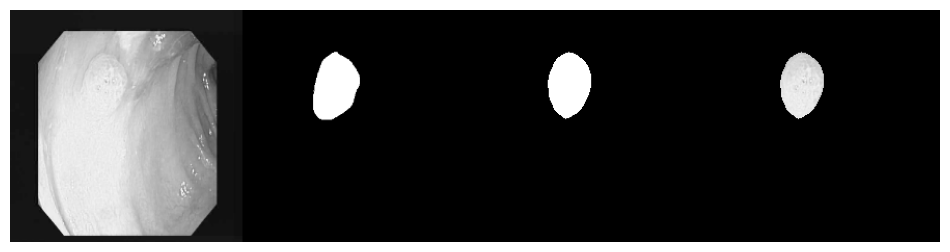

 Epoch: 83 of 100, Iter.: 46 of 46, Train Loss: 0.038097, IoU: 0.946517, Dice: 0.969673
 Epoch: 83 of 100, Iter.: 46 of 46, Valid Loss: 0.309425, IoU: 0.701671, Dice: 0.772089


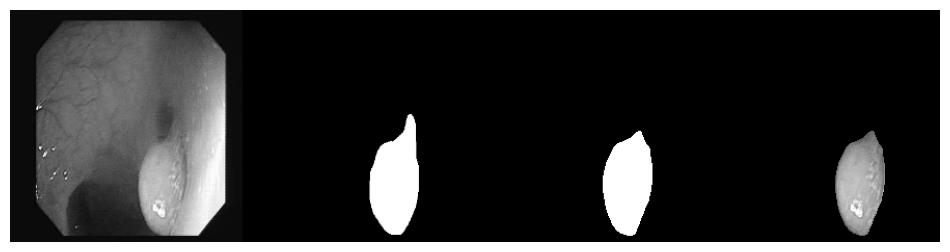

 Epoch: 84 of 100, Iter.: 46 of 46, Train Loss: 0.035302, IoU: 0.949974, Dice: 0.971891
 Epoch: 84 of 100, Iter.: 46 of 46, Valid Loss: 0.330337, IoU: 0.686257, Dice: 0.757205


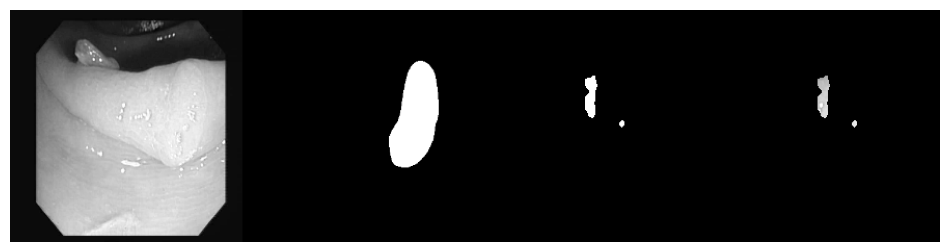

 Epoch: 85 of 100, Iter.: 46 of 46, Train Loss: 0.033831, IoU: 0.953806, Dice: 0.975300
 Epoch: 85 of 100, Iter.: 46 of 46, Valid Loss: 0.311074, IoU: 0.698802, Dice: 0.768796


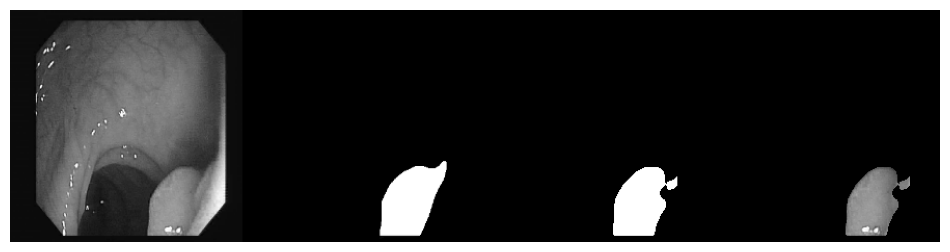

 Epoch: 86 of 100, Iter.: 46 of 46, Train Loss: 0.033945, IoU: 0.952064, Dice: 0.973654
 Epoch: 86 of 100, Iter.: 46 of 46, Valid Loss: 0.330392, IoU: 0.687938, Dice: 0.759408


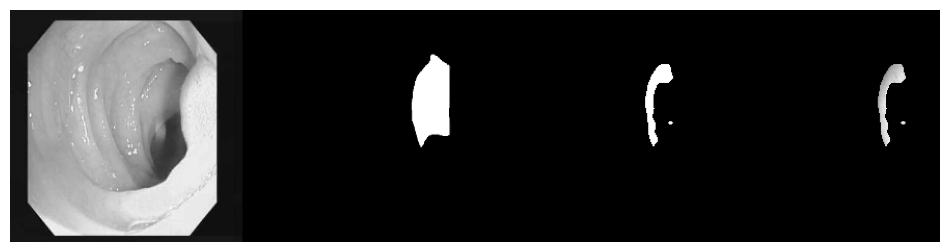

 Epoch: 87 of 100, Iter.: 46 of 46, Train Loss: 0.033730, IoU: 0.954914, Dice: 0.976340
 Epoch: 87 of 100, Iter.: 46 of 46, Valid Loss: 0.313446, IoU: 0.701300, Dice: 0.773763


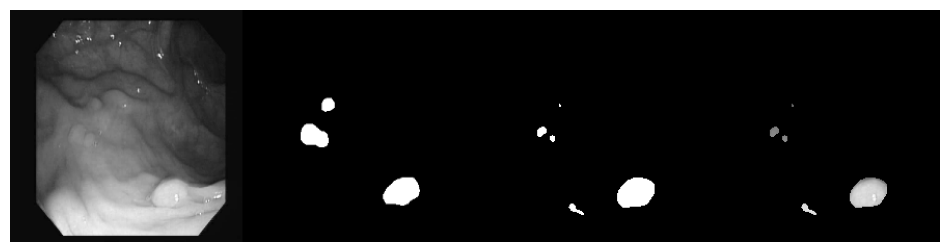

 Epoch: 88 of 100, Iter.: 46 of 46, Train Loss: 0.034384, IoU: 0.953503, Dice: 0.975723
 Epoch: 88 of 100, Iter.: 46 of 46, Valid Loss: 0.305658, IoU: 0.702401, Dice: 0.773417


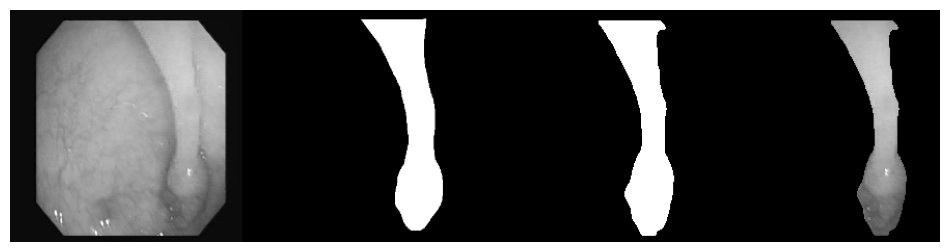

 Epoch: 89 of 100, Iter.: 46 of 46, Train Loss: 0.031916, IoU: 0.956431, Dice: 0.977288
 Epoch: 89 of 100, Iter.: 46 of 46, Valid Loss: 0.299779, IoU: 0.706692, Dice: 0.780749


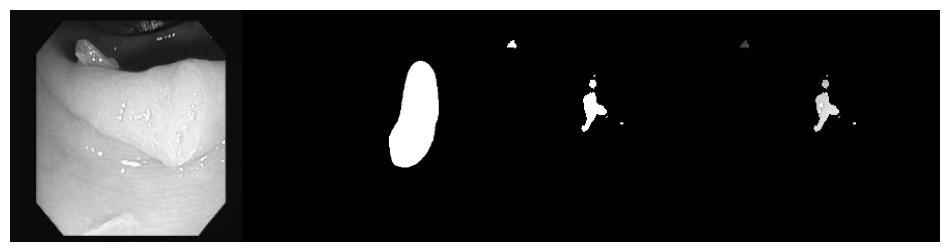

 Epoch: 90 of 100, Iter.: 46 of 46, Train Loss: 0.030807, IoU: 0.959495, Dice: 0.979013
 Epoch: 90 of 100, Iter.: 46 of 46, Valid Loss: 0.310467, IoU: 0.704801, Dice: 0.774385


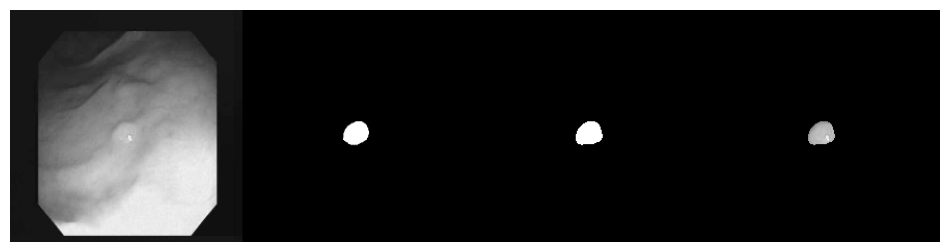

 Epoch: 91 of 100, Iter.: 46 of 46, Train Loss: 0.031495, IoU: 0.957478, Dice: 0.977870
 Epoch: 91 of 100, Iter.: 46 of 46, Valid Loss: 0.302973, IoU: 0.712641, Dice: 0.783347


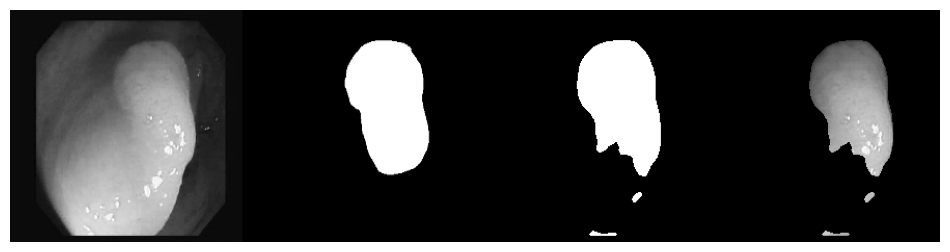

 Epoch: 92 of 100, Iter.: 46 of 46, Train Loss: 0.028180, IoU: 0.961902, Dice: 0.980296
 Epoch: 92 of 100, Iter.: 46 of 46, Valid Loss: 0.310958, IoU: 0.706169, Dice: 0.777543


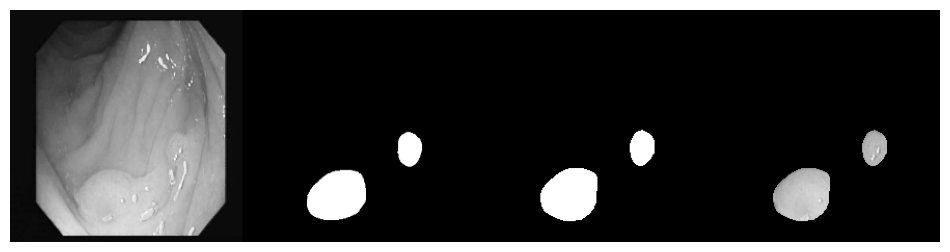

 Epoch: 93 of 100, Iter.: 46 of 46, Train Loss: 0.027338, IoU: 0.962996, Dice: 0.980816
 Epoch: 93 of 100, Iter.: 46 of 46, Valid Loss: 0.312841, IoU: 0.708345, Dice: 0.780191


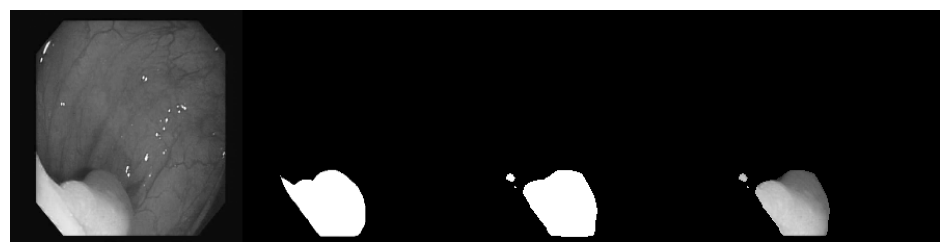

 Epoch: 94 of 100, Iter.: 46 of 46, Train Loss: 0.025761, IoU: 0.964963, Dice: 0.981944
 Epoch: 94 of 100, Iter.: 46 of 46, Valid Loss: 0.311491, IoU: 0.704608, Dice: 0.776485


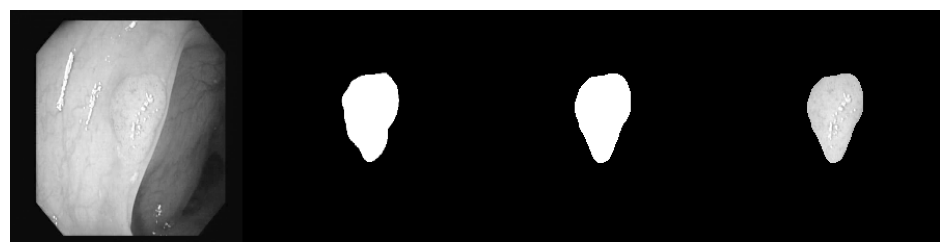

 Epoch: 95 of 100, Iter.: 46 of 46, Train Loss: 0.024523, IoU: 0.966956, Dice: 0.982990
 Epoch: 95 of 100, Iter.: 46 of 46, Valid Loss: 0.311198, IoU: 0.712735, Dice: 0.784588


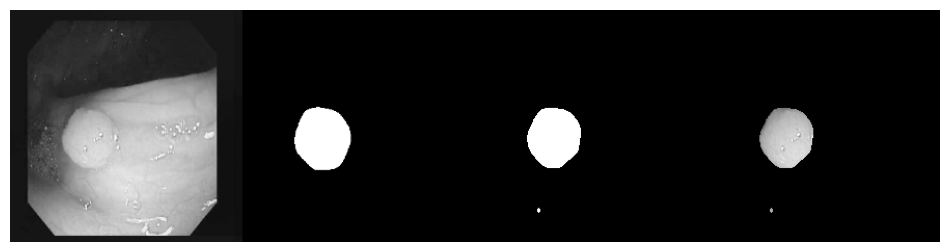

 Epoch: 96 of 100, Iter.: 46 of 46, Train Loss: 0.025120, IoU: 0.966301, Dice: 0.982703
 Epoch: 96 of 100, Iter.: 46 of 46, Valid Loss: 0.310092, IoU: 0.708544, Dice: 0.779011


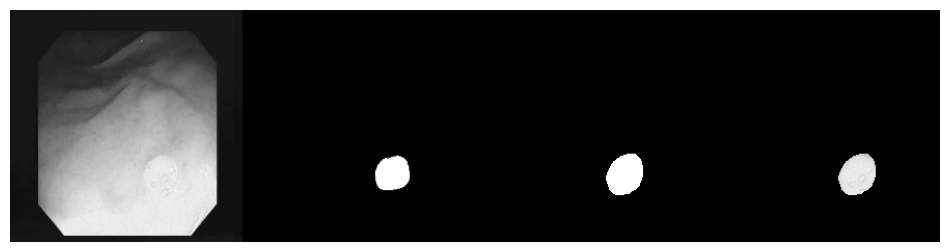

 Epoch: 97 of 100, Iter.: 46 of 46, Train Loss: 0.024599, IoU: 0.966551, Dice: 0.982818
 Epoch: 97 of 100, Iter.: 46 of 46, Valid Loss: 0.304868, IoU: 0.713010, Dice: 0.786145


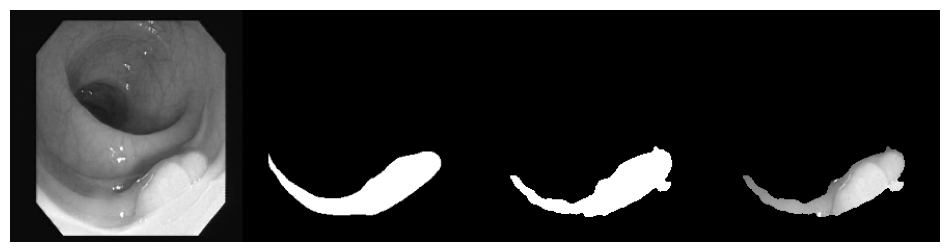

 Epoch: 98 of 100, Iter.: 46 of 46, Train Loss: 0.025347, IoU: 0.965761, Dice: 0.982388
 Epoch: 98 of 100, Iter.: 46 of 46, Valid Loss: 0.325952, IoU: 0.700904, Dice: 0.769786


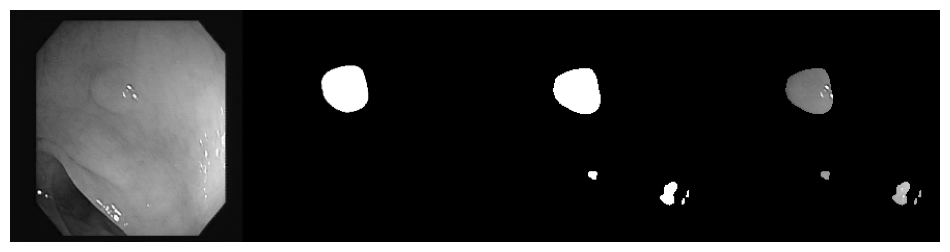

 Epoch: 99 of 100, Iter.: 46 of 46, Train Loss: 0.024538, IoU: 0.966733, Dice: 0.982948
 Epoch: 99 of 100, Iter.: 46 of 46, Valid Loss: 0.308902, IoU: 0.712687, Dice: 0.783822


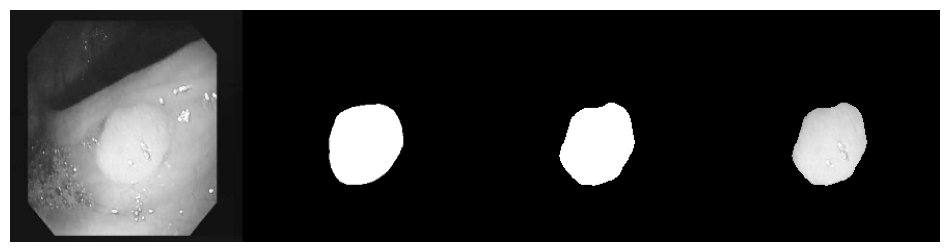

 Epoch: 100 of 100, Iter.: 46 of 46, Train Loss: 0.025478, IoU: 0.965268, Dice: 0.982143
 Epoch: 100 of 100, Iter.: 46 of 46, Valid Loss: 0.331304, IoU: 0.698189, Dice: 0.770930


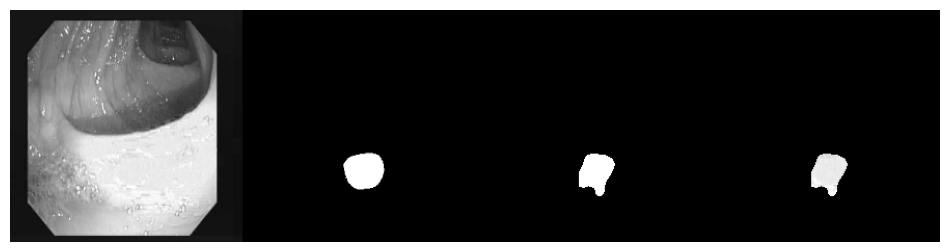

CPU times: user 9min 57s, sys: 6min 50s, total: 16min 48s
Wall time: 9min 52s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:97, Best_IOU:0.7130, Best_DiceScore:0.7861


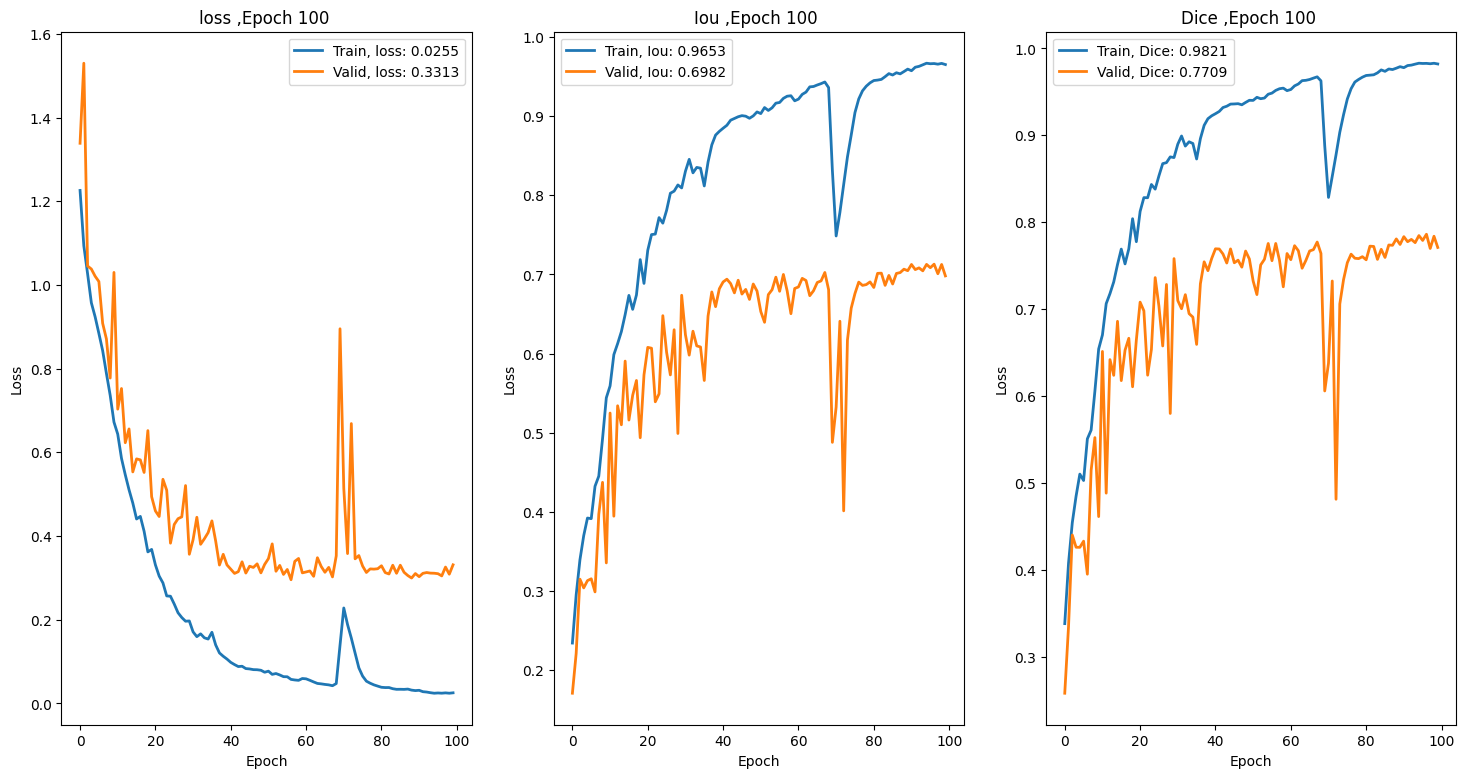

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()